# 1. Pipeline (text_generation)


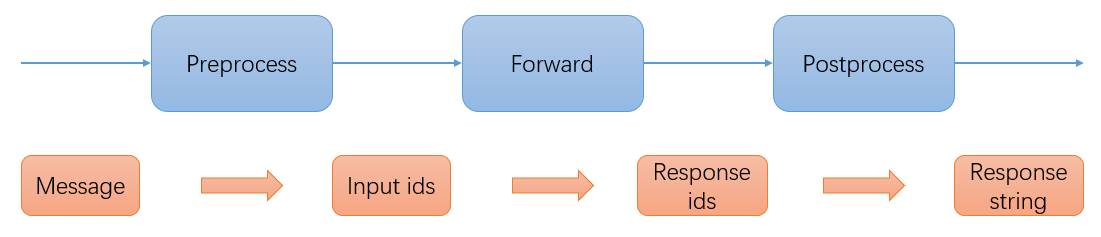

pipeline 模型会自动完成以下三个步骤：
1.   将文本预处理为模型可以理解的格式；
2.   将预处理好的文本送入模型；
3.   对模型的预测值进行后处理，输出人类可以理解的格式。



[pipelines对应代码](https://github.com/huggingface/transformers/blob/0ed3ffcb4461a244b87781a24e5ebd0a78f98142/src/transformers/pipelines/base.py#L786)





```
# 第1259行代码
def run_single(self, inputs, preprocess_params, forward_params, postprocess_params):
    model_inputs = self.preprocess(inputs, **preprocess_params)
    model_outputs = self.forward(model_inputs, **forward_params)
    outputs = self.postprocess(model_outputs, **postprocess_params)
    return outputs
```



## 1.1 Preprocess

[text_generation的pinelines代码](https://github.com/huggingface/transformers/blob/0ed3ffcb4461a244b87781a24e5ebd0a78f98142/src/transformers/pipelines/text_generation.py#L38)



```
# 第276行代码
if isinstance(prompt_text, Chat):
    inputs = self.tokenizer.apply_chat_template(
        prompt_text.messages,
        truncation=truncation,
        padding=padding,
        max_length=max_length,
        add_generation_prompt=True,
        return_dict=True,
        return_tensors=self.framework,
    )
else:
    inputs = self.tokenizer(
        prefix + prompt_text,
        truncation=truncation,
        padding=padding,
        max_length=max_length,
        add_special_tokens=add_special_tokens,
        return_tensors=self.framework,
    )
```



* 进行的处理的示例：


1.   假设整个聊天对话内容是:

`message = [
  {"role": "user", "content": "Hello, how are you?"},
  {"role": "assistant", "content": "I'm doing great. How can I help you today?"},
  {"role": "user", "content": "I'd like to show off how chat templating works!"},
]`

则会将整个聊天对话内容压缩成一整个字符串：

<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n
Hello, how are you?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n
I'm doing great. How can I help you today?<|eot_id|><|start_header_id|>user<|end_header_id|>\n
I'd like to show off how chat templating works!<|eot_id|>

2.   sequence→token:

['<|begin_of_text|>', '<|start_header_id|>', 'user', '<|end_header_id|>', 'ĊĊ', 'Hello', ',', 'Ġhow', 'Ġare', 'Ġyou', '?', '<|eot_id|>', '<|start_header_id|>', 'assistant', '<|end_header_id|>', 'ĊĊ', 'I', "'m", 'Ġdoing', 'Ġgreat', '.', 'ĠHow', 'Ġcan', 'ĠI', 'Ġhelp', 'Ġyou', 'Ġtoday', '?', '<|eot_id|>', '<|start_header_id|>', 'user', '<|end_header_id|>', 'ĊĊ', 'I', "'d", 'Ġlike', 'Ġto', 'Ġshow', 'Ġoff', 'Ġhow', 'Ġchat', 'Ġtempl', 'ating', 'Ġworks', '!', '<|eot_id|>']

3.   token→ids:

[128000, 128006, 882, 128007, 271, 9906, 11, 1268, 527, 499, 30, 128009, 128006, 78191, 128007, 271, 40, 2846, 3815, 2294, 13, 2650, 649, 358, 1520, 499, 3432, 30, 128009, 128006, 882, 128007, 271, 40, 4265, 1093, 311, 1501, 1022, 1268, 6369, 68630, 1113, 4375, 0, 128009]





* 对于数字的处理([demo](https://github.com/belladoreai/llama3-tokenizer-js)):

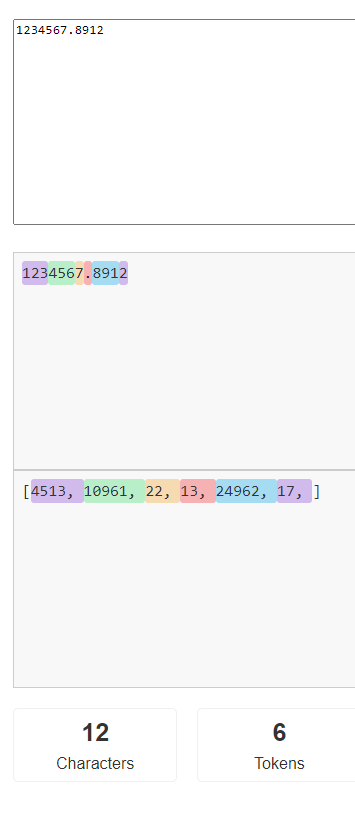


### 1.1.1 apply_chat_template

[apply_chat_template对应的代码](https://github.com/huggingface/transformers/blob/0ed3ffcb4461a244b87781a24e5ebd0a78f98142/src/transformers/tokenization_utils_base.py#L3249)



```
# 第1867行代码
if tokenize:
    out = self(
        rendered,
        padding=padding,
        truncation=truncation,
        max_length=max_length,
        add_special_tokens=False,
        return_tensors=return_tensors,
        **tokenizer_kwargs,
    )
    if return_dict:
        return out
    else:
        return out["input_ids"]
else:
    return rendered
```



### 1.1.2 self→call→call_one→...→_batch_encode_plus→encode_batch

[call对应的代码](https://github.com/huggingface/transformers/blob/0ed3ffcb4461a244b87781a24e5ebd0a78f98142/src/transformers/tokenization_utils_base.py#L3249)

* call_one→batch_encode_plus→_batch_encode_plus


* call_one→encode_plus→_encode_plus→_batch_encode_plus

[_batch_encode_plus对应的代码](https://github.com/huggingface/transformers/blob/main/src/transformers/tokenization_utils_fast.py#L528)



```
# 第528行代码
encodings = self._tokenizer.encode_batch(
    batch_text_or_text_pairs,
    add_special_tokens=add_special_tokens,
    is_pretokenized=is_split_into_words,
)
```



* encode_batch调用的huggingface的tokenizers库

[huggingface的llama3-8B的tokenizer_config.json选的"tokenizer_class": "PreTrainedTokenizerFast"](https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct/blob/main/tokenizer_config.json)

[encode_batch对应的代码](https://github.com/huggingface/tokenizers/blob/fdd26ba9a3f0c133427aab0423888cbde91362d7/bindings/python/py_src/tokenizers/implementations/base_tokenizer.py#L225)



```
# 第225行代码
def encode_batch(
    self,
    inputs: List[EncodeInput],
    is_pretokenized: bool = False,
    add_special_tokens: bool = True,
) -> List[Encoding]:
    """Encode the given inputs. This method accept both raw text sequences as well as already
    pre-tokenized sequences.

    Args:
        inputs: List[EncodeInput]:
            A list of single sequences or pair sequences to encode. Each `EncodeInput` is
            expected to be of the following form:
                `Union[InputSequence, Tuple[InputSequence, InputSequence]]`

            Each `InputSequence` can either be raw text or pre-tokenized,
            according to the `is_pretokenized` argument:

            - If `is_pretokenized=False`: `InputSequence` is expected to be `str`
            - If `is_pretokenized=True`: `InputSequence` is expected to be
                `Union[List[str], Tuple[str]]`

        is_pretokenized: bool:
            Whether the input is already pre-tokenized.

        add_special_tokens: bool:
            Whether to add the special tokens while encoding.

    Returns:
        A list of Encoding
    """

    if inputs is None:
        raise ValueError("encode_batch: `inputs` can't be `None`")

    return self._tokenizer.encode_batch(inputs, is_pretokenized, add_special_tokens)
```



### 1.1.3 其它

tokenizer可调用的函数:

[链接1](https://huggingface.co/docs/transformers/main/en/main_classes/tokenizer)

[链接2](https://huggingface.co/docs/transformers/main/en/internal/tokenization_utils)

## 1.2 Forward

[text_generation的_forward代码](https://github.com/huggingface/transformers/blob/0ed3ffcb4461a244b87781a24e5ebd0a78f98142/src/transformers/pipelines/text_generation.py#L319)

huggingface的[llama3-8B](https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct/blob/main/config.json)的config.json选的[LlamaForCausalLM模型代码](https://github.com/huggingface/transformers/blob/7e86cb6c6f126b5d283d61b48e1879023c11086a/src/transformers/models/llama/modeling_llama.py#L1088)

* **输出:**

    响应的toekn对应的ids





## 1.3 Postprocess

[text_generation的postprocess代码](https://github.com/huggingface/transformers/blob/0ed3ffcb4461a244b87781a24e5ebd0a78f98142/src/transformers/pipelines/text_generation.py#L319)

转换字符串中的ID序列，使用带有选项的标记器和词汇表来删除特殊标记并清理标记空间。类似于做self.convert_tokens_to_string(self.convert_ids_to_tokens(token_ids))，即ids→token→sequence。


# 2. 在AWS EC2上部署LLAMA3

## 2.1 安装miniconda

1. 安装命令

```
mkdir -p ~/miniconda3
wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh -O ~/miniconda3/miniconda.sh
bash ~/miniconda3/miniconda.sh -b -u -p ~/miniconda3
rm -rf ~/miniconda3/miniconda.sh
```



2. 初始化命令

```
~/miniconda3/bin/conda init bash
~/miniconda3/bin/conda init zsh
```



3. 重新打开终端

## 2.2 配置环境

1. 新键conda子环境

```
conda create -n llama3 python=3.10
conda activate llama3
```



2. 新建requirements.txt文件，插入：

```
torch
fairscale
fire
tiktoken==0.4.0
blobfile
transformers
peft
accelerate
```



3. 执行

```
pip install -r requirements.txt
```



## 2.3 获取huggingface模型权重下载许可

1. 安装相关的库

```
pip install -U "huggingface_hub[cli]"
```



2. 登陆命令

```
huggingface-cli login --token $HUGGINGFACE_TOKEN # --add-to-git-credential
```



## 2.4 运行demo



```
import transformers
import torch

model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto",
)

terminators = [
    pipeline.tokenizer.eos_token_id,
    pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

messages = [
    {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"}
    ]

while True:

    # 从终端接收用户输入的文本
    user_input = input("请输入一些文本（输入'exit'或'quit'退出程序）: ")

    # 判断是否要退出程序
    if user_input.lower() in ['exit', 'quit']:
        print("程序已退出。")
        break

    messages.append({"role": "user", "content": user_input})
    
    outputs = pipeline(
        messages,
        max_new_tokens=256,
        eos_token_id=terminators,
        do_sample=True,
        temperature=0.6,
        top_p=0.9,
    )
    print('llama3的回应：',outputs[0]["generated_text"][-1])
    messages.append({"role": "assistant", "content": outputs[0]["generated_text"][-1]})

```



执行transformers.pipeline时，默认HuggingFace的缓存模型会保存在/root/.cache目录，如果不想将模型权重放在系统盘，而是想将其放在数据盘，可以通过以下方法实现：

```
# 终端中执行：
export TRANSFORMERS_CACHE= 数据盘路径

```

